# Delimiter Analysis

In [19]:
import sys

sys.path.append("../src")
import train

In [20]:
import torch

RUN = "../nlab-gpt-medium-8.7M.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run = train.Run.from_file(RUN)
run.model.to(device)
None  # No output

In [21]:
val_data = torch.load("../data/val_data.pt").to(device)

In [107]:
import collections


class UnbalancedDelimiter(Exception): ...


# Compute the token positions of every balanced delimiters '(' and ')'
# LIMITATION: Weird tokens like "((", "))", ")(" are naively handled.
def get_delimiters(input_ids, allow_unmatched_opened=True):
    tokens = [run.tokenizer.decode([i]) for i in input_ids]
    opened = []
    pairs = []
    for n, token in enumerate(tokens):
        for char in token:
            match char:
                case "(":
                    opened.append((n, token))
                case ")":
                    if not opened:
                        raise UnbalancedDelimiter("Found ')' with empty stack")
                    i, otoken = opened.pop()
                    # We only push pairs of distinguishable tokens
                    co, cc = collections.Counter(otoken), collections.Counter(token)
                    if co["("] == 1 and co[")"] == 0 and cc["("] == 0 and cc[")"] == 1:
                        pairs.append((i, n))
    if not allow_unmatched_opened and opened:
        raise UnbalancedDelimiter(f"Unmatched '(' remaining: {len(opened)}")
    return pairs


# Generate a batch of sequences with balanced delimiters
def get_batch(
    run,
    oversample_factor=8,
    max_rounds=200,
    min_pairs=1,
    allow_unmatched_opened=True,
):
    N = val_data.size(0)
    B = run.config.per_device_train_batch_size
    T = run.config.max_position_embeddings

    ar = torch.arange(T, device=device)[None, :]  # (1, T)

    xs = []
    xpairs = []

    for _ in range(max_rounds):
        K = oversample_factor * (B - len(xs))
        if K <= 0:
            break

        start = torch.randint(0, N - T - 1, (K,), device=device)
        pos = start[:, None] + ar  # (K, T)

        xk = val_data[pos].to(device)  # (K, T)

        for i in range(K):
            x = xk[i]
            try:
                pairs = get_delimiters(
                    x,
                    allow_unmatched_opened=allow_unmatched_opened,
                )
            except UnbalancedDelimiter:
                continue
            if len(pairs) < min_pairs:
                continue

            xs.append(x)
            xpairs.append(pairs)

            if len(xs) == B:
                break

        if len(xs) == B:
            break

    if len(xs) < B:
        raise RuntimeError(
            f"Could not fill batch: got {len(xs)}/{B} balanced windows after "
            f"{max_rounds} rounds. Try lowering T, lowering min_pairs, or increasing oversample_factor."
        )

    return torch.stack(xs, dim=0), xpairs

In [169]:
import matplotlib.pyplot as plt
import numpy as np


def get_cms_hits(run, max_iters=20, top_k=10):
    score = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.float64
    )
    count = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )

    hit = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )
    total = np.zeros(
        (run.config.num_hidden_layers, run.config.num_attention_heads), dtype=np.int64
    )

    for _ in range(max_iters):
        input_ids, pairs = get_batch(run, min_pairs=2)

        opens = [sorted({o for o, c in l}) for l in pairs]

        def attention_callback(layer, head, attn_weight):
            B, T, _ = attn_weight.shape

            for b in range(B):
                for o, c in pairs[b]:
                    top = np.argsort(attn_weight[b, c, : c + 1])[-top_k:]
                    hit[layer][head] += int(o in top)

                    cand = [o2 for o2 in opens[b] if o2 < c and o2 != o]
                    if not cand:
                        continue

                    score[layer][head] += attn_weight[b][c][o] - sum(
                        attn_weight[b][c][o2] for o2 in cand
                    ) / len(cand)
                    count[layer][head] += 1
            total[layer][head] += B * sum(len(p) for p in pairs)

        with torch.no_grad():
            run.model(input_ids, attention_callback=attention_callback)

    outs = np.zeros_like(score)
    mask = count > 0
    outs[mask] = score[mask] / count[mask]

    outh = np.zeros_like(hit, dtype=np.float64)
    mask = total > 0
    outh[mask] = hit[mask] / total[mask]
    # ((L, H), (L, H))
    return outs, outh


def show_cms_hits(run, vals=[], top_k=10):

    fig, axes = plt.subplots(
        nrows=2,
        ncols=len(vals),
    )

    for n, score, hit in zip(
        range(len(vals)), list(zip(*vals))[0], list(zip(*vals))[1]
    ):
        ax = axes[0, n]

        ax.set_xticks(range(run.config.num_attention_heads))
        ax.set_xticklabels(
            [f"Head {h}" for h in range(run.config.num_attention_heads)],
            fontsize=6,
            rotation=90,
        )

        ax.set_yticks(range(run.config.num_hidden_layers))
        ax.set_yticklabels(
            [f"Layer {l}" for l in range(run.config.num_hidden_layers)], fontsize=6
        )

        for spine in ax.spines.values():
            spine.set_visible(False)

        ax.imshow(
            score,
            cmap="viridis",
            aspect="equal",
            interpolation="nearest",
            origin="upper",
        )
        ax.set_title(f"Round {n}")

        if n == 0:
            ax.set_ylabel(f"CMS")

        ax = axes[1, n]

        ax.set_xticks(range(run.config.num_attention_heads))
        ax.set_xticklabels(
            [f"Head {h}" for h in range(run.config.num_attention_heads)],
            fontsize=6,
            rotation=90,
        )

        ax.set_yticks(range(run.config.num_hidden_layers))
        ax.set_yticklabels(
            [f"Layer {l}" for l in range(run.config.num_hidden_layers)], fontsize=6
        )

        for spine in ax.spines.values():
            spine.set_visible(False)

        ax.imshow(
            hit,
            cmap="viridis",
            aspect="equal",
            interpolation="nearest",
            origin="upper",
        )

        if n == 0:
            ax.set_ylabel(f"%Hit (Top {top_k})")

    plt.suptitle(
        f"Contrastive Matching Score for '(', ')' + %Hit (Top {top_k}): {run.name[:-9]}"
    )
    plt.tight_layout()
    plt.savefig(f"../assets/cms-{run.name[:-9]}.png", dpi=300, bbox_inches="tight")
    plt.show()

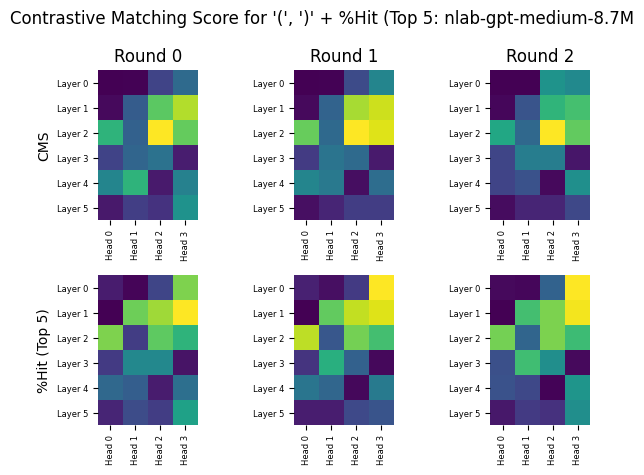

In [168]:
show_cms_hits(run, [get_cms_hits(run, max_iters=1, top_k=5) for _ in range(3)], top_k=5)

In [174]:
import pathlib

import matplotlib.colors as mcolors
import tqdm

CHECKPOINTS = "../runs/nlab-gpt-medium-8.7M-eb4543e4"

steps = []
max_cms_global = [[] for _ in range(run.config.num_hidden_layers)]
gap_cms_global = [[] for _ in range(run.config.num_hidden_layers)]

for path in tqdm.notebook.tqdm(
    list(pathlib.Path(CHECKPOINTS).rglob("*.pt")), desc="Processing", unit="checkpoints"
):
    path = str(path)
    # Skip the final checkpoint
    if path.endswith("-[final].pt"):
        continue
    run = train.Run.from_file(path)

    steps.append(run.global_step)
    # ((L, H), (L, H))
    cms, hit = get_cms_hits(run, max_iters=1, top_k=5)

    max_cms = cms.max(axis=1)
    gap_cms = max_cms - np.median(cms, axis=1)

    for l in range(run.config.num_hidden_layers):
        max_cms_global[l].append(max_cms[l])
        gap_cms_global[l].append(gap_cms[l])

values = np.linspace(0, 5, run.config.num_hidden_layers)
norm = mcolors.Normalize(vmin=values.min(), vmax=values.max())
cmap = plt.cm.viridis

Processing:   0%|          | 0/56 [00:00<?, ?checkpoints/s]

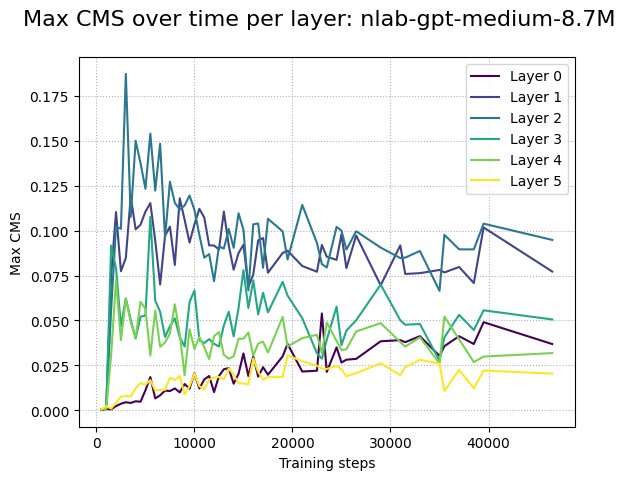

In [175]:
for l, v in enumerate(values):
    plt.plot(steps, max_cms_global[l], label=f"Layer {l}", color=cmap(norm(v)))

plt.xlabel("Training steps")
plt.ylabel("Max CMS")

plt.suptitle(f"Max CMS over time per layer: {run.name[:-9]}", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig("../assets/max-cms.png", dpi=300, bbox_inches="tight")
plt.show()

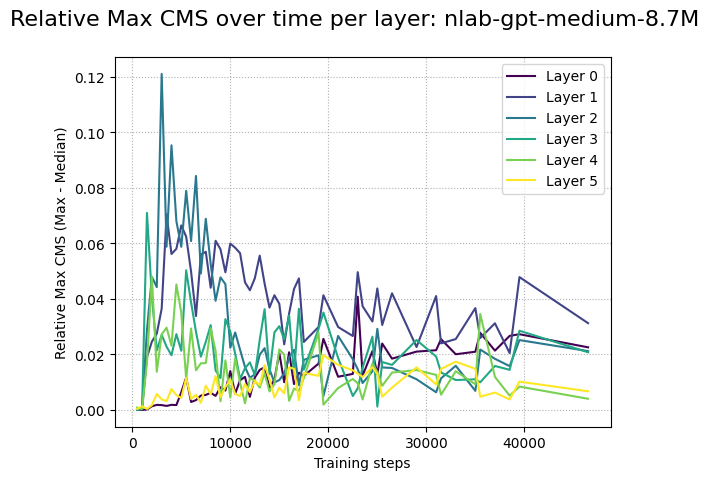

In [177]:
for l, v in enumerate(values):
    plt.plot(steps, gap_cms_global[l], label=f"Layer {l}", color=cmap(norm(v)))

plt.xlabel("Training steps")
plt.ylabel("Relative Max CMS (Max - Median)")

plt.suptitle(f"Relative Max CMS over time per layer: {run.name[:-9]}", fontsize=16)
plt.legend()
plt.grid(which="both", linestyle="dotted")

plt.savefig("../assets/gap-cms.png", dpi=300, bbox_inches="tight")
plt.show()